In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

In [2]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [19]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        train_loss += F.nll_loss(output.log(), target).item()
        pred = output.detach().max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(f'Epoch: {epoch} | Loss: {loss.item():.6f} | Accuracy: {correct / len(train_loader.dataset) : .6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'Loss: {test_loss:.6f} | Accuracy: {correct / len(test_loader.dataset) : .6f}')

In [7]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 32158882.85it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 10140272.38it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw




100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 9008832.33it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 6289378.93it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [20]:
model = Net()
model.to(device)
model

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [21]:
num_epochs = 5
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.838205 | Accuracy:  0.455350
Loss: 0.005633 | Accuracy:  0.878400
Epoch: 2 | Loss: 0.464310 | Accuracy:  0.794917
Loss: 0.003219 | Accuracy:  0.917800
Epoch: 3 | Loss: 0.679042 | Accuracy:  0.853183
Loss: 0.002261 | Accuracy:  0.943800
Epoch: 4 | Loss: 0.313553 | Accuracy:  0.882533
Loss: 0.001715 | Accuracy:  0.952800
Epoch: 5 | Loss: 0.232040 | Accuracy:  0.901450
Loss: 0.001410 | Accuracy:  0.960000


In [22]:
batch = next(iter(test_loader))
images, _ = batch
images.shape

torch.Size([128, 1, 28, 28])

In [28]:
background = images[:100]
test_images = images[100:103]
background.shape, test_images.shape

(torch.Size([100, 1, 28, 28]), torch.Size([3, 1, 28, 28]))

In [33]:
model.to('cpu')
explainer = shap.DeepExplainer(model, background)
explainer

In [36]:
shap_values = e.shap_values(test_images)
shap_values.shape

(3, 1, 28, 28, 10)

In [40]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
len(shap_numpy), test_numpy.shape

(10, (3, 28, 28, 1))

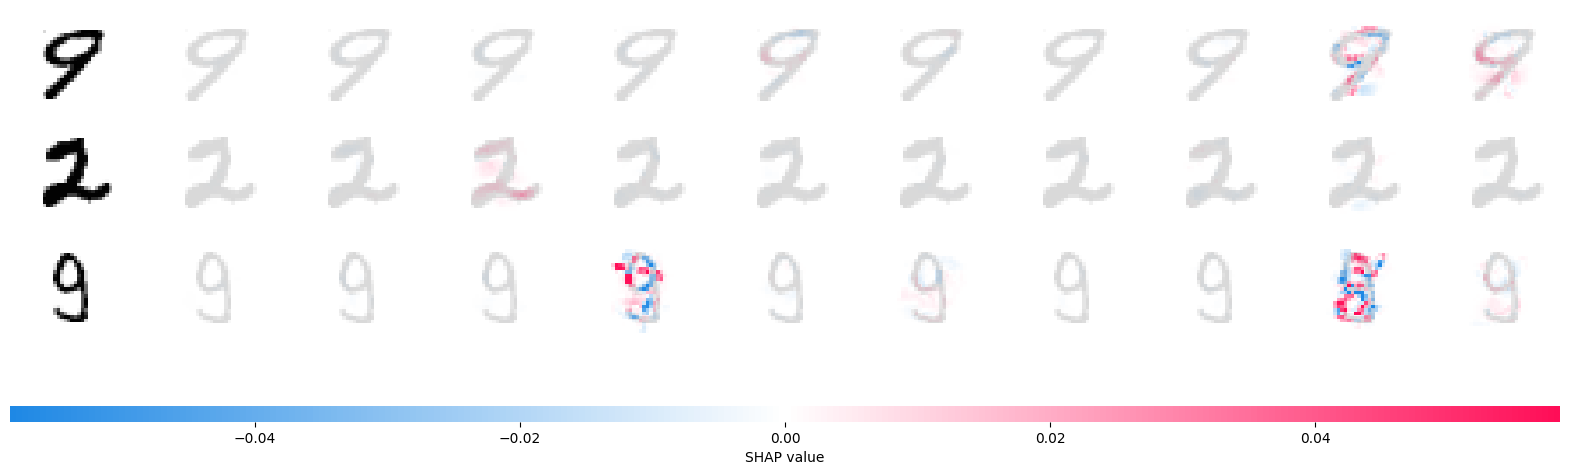

In [41]:
shap.image_plot(shap_numpy, -test_numpy)